In [1]:
import re
import numpy as np
import string
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

In [2]:
sentences = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""

In [3]:
# clean data
# remove special characters
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)

# remove 1 letter words
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()

# lower all characters
sentences = sentences.lower()

In [4]:
words = sentences.split()
print(words)
vocab = set(words) # loại bỏ những từ giống nhau
print(vocab)

['we', 'are', 'about', 'to', 'study', 'the', 'idea', 'of', 'computational', 'process', 'computational', 'processes', 'are', 'abstract', 'beings', 'that', 'inhabit', 'computers', 'as', 'they', 'evolve', 'processes', 'manipulate', 'other', 'abstract', 'things', 'called', 'data', 'the', 'evolution', 'of', 'process', 'is', 'directed', 'by', 'pattern', 'of', 'rules', 'called', 'program', 'people', 'create', 'programs', 'to', 'direct', 'processes', 'in', 'effect', 'we', 'conjure', 'the', 'spirits', 'of', 'the', 'computer', 'with', 'our', 'spells']
{'by', 'things', 'to', 'process', 'abstract', 'people', 'directed', 'spirits', 'called', 'in', 'the', 'beings', 'we', 'evolve', 'inhabit', 'computers', 'other', 'rules', 'is', 'they', 'are', 'effect', 'with', 'program', 'our', 'programs', 'idea', 'computational', 'manipulate', 'conjure', 'about', 'spells', 'study', 'evolution', 'of', 'processes', 'create', 'that', 'direct', 'computer', 'as', 'pattern', 'data'}


In [5]:
vocab_size = len(vocab)
embed_dim = 10
context_size = 2 # nó là window_size
# 2 từ đằng trước và 2 từ đằng sau

In [30]:
# Đánh chỉ số cho vocab
word_to_ix = {word: i for i, word in enumerate(vocab)}
print(word_to_ix)
ix_to_word = {i: word for i, word in enumerate(vocab)}
print(ix_to_word)

{'by': 0, 'things': 1, 'to': 2, 'process': 3, 'abstract': 4, 'people': 5, 'directed': 6, 'spirits': 7, 'called': 8, 'in': 9, 'the': 10, 'beings': 11, 'we': 12, 'evolve': 13, 'inhabit': 14, 'computers': 15, 'other': 16, 'rules': 17, 'is': 18, 'they': 19, 'are': 20, 'effect': 21, 'with': 22, 'program': 23, 'our': 24, 'programs': 25, 'idea': 26, 'computational': 27, 'manipulate': 28, 'conjure': 29, 'about': 30, 'spells': 31, 'study': 32, 'evolution': 33, 'of': 34, 'processes': 35, 'create': 36, 'that': 37, 'direct': 38, 'computer': 39, 'as': 40, 'pattern': 41, 'data': 42}
{0: 'by', 1: 'things', 2: 'to', 3: 'process', 4: 'abstract', 5: 'people', 6: 'directed', 7: 'spirits', 8: 'called', 9: 'in', 10: 'the', 11: 'beings', 12: 'we', 13: 'evolve', 14: 'inhabit', 15: 'computers', 16: 'other', 17: 'rules', 18: 'is', 19: 'they', 20: 'are', 21: 'effect', 22: 'with', 23: 'program', 24: 'our', 25: 'programs', 26: 'idea', 27: 'computational', 28: 'manipulate', 29: 'conjure', 30: 'about', 31: 'spells'

In [31]:
# data - [(context), target]
# dùng để tạo dataset từ sentences
data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))
print(data[:5])

[(['we', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'computational'], 'idea')]


In [32]:
embeddings =  np.random.random_sample((vocab_size, embed_dim))
print(embeddings[0].shape)

(10,)


In [48]:
def linear(m, theta):
  #parameters: m: inputs , theta: weights matrix
    w = theta
    return m.dot(w)

In [49]:
def log_softmax(x):
    e_x = np.exp(x - np.max(x))# bước này dùng để tránh overflow khi tính exp()
    return np.log(e_x / e_x.sum())

In [50]:
def NLLLoss(logs, targets):
  # Negative Log-Likelihood Loss
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)

In [51]:
def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1

    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    return (- out + softmax) / logits.shape[0]
# ∂Loss/∂logits = (softmax - one_hot_target) / batch_size (=1)

In [52]:
def forward(context_idxs, theta):
  # lấy embeddings tương ứng và ghép lại thành 1 vector dài
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = log_softmax(n)
    return m, n, o

In [53]:
# hàm này dùng để đạo hàm
def backward(preds, theta, target_idxs):
    m, n, o = preds

    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
    dw = m.T.dot(dlog)

    return dw

In [54]:
def optimize(theta, grad, lr=0.03):
    theta -= grad * lr
    return theta

In [55]:
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))
print(theta.T.shape)

(43, 40)


In [56]:
epoch_losses = {}

for epoch in range(80):

    losses =  []

    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])
        preds = forward(context_idxs, theta)

        target_idxs = np.array([word_to_ix[target]])
        loss = NLLLoss(preds[-1], target_idxs)

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)
        theta = optimize(theta, grad, lr=0.03)

    epoch_losses[epoch] = losses

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


Text(0, 0.5, 'Losses')

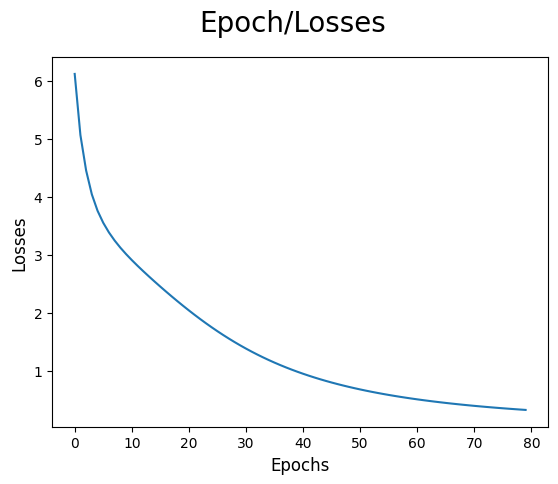

In [18]:
ix = np.arange(0,80)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

In [19]:
def predict(words):
    context_idxs = np.array([word_to_ix[w] for w in words])
    preds = forward(context_idxs, theta)
    word = ix_to_word[np.argmax(preds[-1])]

    return word

In [20]:
# (['we', 'are', 'to', 'study'], 'about')
predict(['we', 'are', 'to', 'study'])

'about'

In [21]:
def accuracy():
    wrong = 0
    for context, target in data:
        if(predict(context) != target):
            wrong += 1

    return (1 - (wrong / len(data)))

In [22]:
accuracy()

1.0